# Section I: Satellite image analysis


In [1]:
import platform
platform.python_version()

'3.9.15'

In [2]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import pandas as pd
import os
from rasterio.plot import show, adjust_band
from shapely.geometry import Polygon, Point

In [6]:
os.listdir("tif/")

['.DS_Store', 'satellite_20221203.tiff']

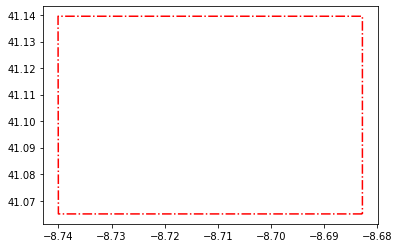

In [4]:
plg = pd.read_csv("csv/polygon.csv").to_numpy()
plg_sh = Polygon(plg)

plt.plot(plg[:, 1], plg[:, 0], 'r-.')

hello


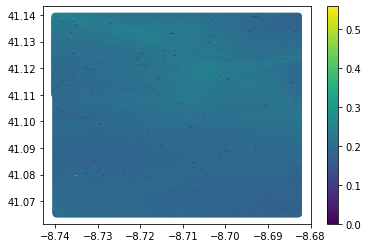

In [7]:
"""
Section for Satellite
"""
@np.vectorize
def get_legal_indices(lat, lon) -> bool:
    point = Point(lat, lon)
    legal = False
    if plg_sh.contains(point):
        legal = True
    return legal


file = "tif/satellite_20221203.tiff"
img = rasterio.open(file)
# img = georaster.MultiBandRaster(file)
b1 = img.read(1)
b2 = img.read(2)
b3 = img.read(3)

print("hello")
height = b1.shape[0]
width = b1.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(img.transform, rows, cols)
lons = np.array(xs).flatten()
lats = np.array(ys).flatten()

b1 = b1.flatten()
b2 = b2.flatten()
b3 = b3.flatten()

ind_legal = get_legal_indices(lats, lons)

#%%
bimg = b1 + b2 + b3
plt.scatter(lons[ind_legal], lats[ind_legal], c=bimg[ind_legal])
plt.colorbar()
plt.show()

In [9]:
lat_selected = lats[ind_legal]
lon_selected = lons[ind_legal]
val = bimg[ind_legal]



In [10]:
import pandas as pd

In [ ]:
data_satellite = np.stack((lat_selected, lon_selected, val), axis=1)
df = pd.DataFrame(data_satellite, columns=['lat', 'lon', 'value'])
df.to_csv()